# 环境
本教程基于paddle2.0-alpha编写，如果您的环境不是本版本，请先安装paddle2.0-alpha。

In [295]:
import paddle
paddle.__version__

'2.0.0-alpha0'

In [296]:
#数据准备
#数据处理部分之前的代码，加入部分数据处理的库
import paddle
from paddle.imperative import to_variable
import numpy as np
import os
import gzip #解压缩包，python自带的包
import json
import random
import matplotlib.pyplot as plt

# 1.数据读取与数据集划分
加载json数据文件。

In [297]:
# 声明数据集文件位置
datafile = '/Users/liushuangqiao/Downloads/mnist.json.gz'
print('loading mnist dataset from {} ......'.format(datafile))
# 加载json数据文件
data = json.load(gzip.open(datafile))
print('mnist dataset load done')
# 读取到的数据区分训练集，验证集，测试集
train_set, val_set, eval_set = data

# 数据集相关参数，图片高度IMG_ROWS, 图片宽度IMG_COLS
IMG_ROWS = 28
IMG_COLS = 28

# 打印数据信息
imgs, labels = train_set[0], train_set[1]
print("训练数据集数量: ", len(imgs),len(labels))

# 观察验证集数量
imgs, labels = val_set[0], val_set[1]
print("验证数据集数量: ", len(imgs),len(labels))

# 观察测试集数量
imgs, labels = val= eval_set[0], eval_set[1]
print("测试数据集数量: ", len(imgs),len(labels))

loading mnist dataset from /Users/liushuangqiao/Downloads/mnist.json.gz ......
mnist dataset load done
训练数据集数量:  50000 50000
验证数据集数量:  10000 10000
测试数据集数量:  10000 10000


# 2. 通过DataSet与DataLoader获取数据

In [298]:
from paddle.io import Dataset

#定义Dataset类对象
class RandomDataset(Dataset):
    def __init__(self, imgs, labels):
        self.imgs = imgs
        self.labels = labels
 
    def __getitem__(self, idx):
        img = self.imgs[idx]
        label = self.labels[idx]
        return img, label
 
    def __len__(self):
        return len(self.imgs)


In [299]:
#通过DataLoader读取dataset数据，涉及必要参数 ：dataset、places=None、batch_size
def load_data_new(mode='train'):
    datafile = '/Users/liushuangqiao/Downloads/mnist.json.gz'
    print('loading mnist dataset from {} ......'.format(datafile))
    # 定义批大小
    BATCH_SIZE = 64
  # 加载json数据文件
    data = json.load(gzip.open(datafile))
    print('mnist dataset load done')
    # 读取到的数据区分训练集，验证集，测试集
    train_set, val_set, eval_set = data
    if mode=='train':
        # 获得训练数据集
        imgs, labels = train_set[0], train_set[1]
    elif mode=='valid':
        # 获得验证数据集
        imgs, labels = val_set[0], val_set[1]
    elif mode=='eval':
        # 获得测试数据集
        imgs, labels = eval_set[0], eval_set[1]
    else:
        raise Exception("mode can only be one of ['train', 'valid', 'eval']")
    dataset = RandomDataset(imgs, labels)
    loader = paddle.io.DataLoader(dataset, places=paddle.CPUPlace(),batch_size=BATCH_SIZE, drop_last=True)
    return loader

# 3. 数据校验

loading mnist dataset from /Users/liushuangqiao/Downloads/mnist.json.gz ......
mnist dataset load done
[64, 784] [64] <class 'paddle.fluid.core_avx.VarBase'> <class 'paddle.fluid.core_avx.VarBase'>

打印第一个batch的第一个图像，对应标签数字为[5]


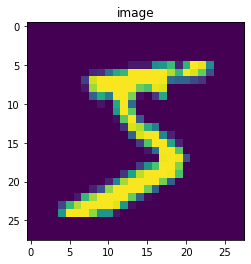

In [300]:
#声明数据读取函数，从训练集中读取数据
paddle.enable_imperative()
train_loader = load_data_new('train')
for batch_id, data in enumerate(train_loader()):

    image_data, label_data = data[0], data[1]    
    if batch_id == 0:
        # 打印数据shape和类型
        print(image_data.shape, label_data.shape, type(image_data), type(label_data))
        print("\n打印第一个batch的第一个图像，对应标签数字为{}".format(label_data[0].numpy()))
        # 原始数据是归一化后的数据，因此这里需要反归一化
        img = np.array(image_data[0]+1)*127.5
        img = np.reshape(img, [28, 28]).astype(np.uint8)
        plt.figure("Image") # 图像窗口名称
        plt.imshow(img)
        plt.axis('on') # 关掉坐标轴为 off
        plt.title('image') # 图像题目
        plt.show()
    break

# 4. 组成网络

In [301]:
from paddle.nn import Conv2D, Pool2D, Linear
#定义网络结构，这里使用最简单的线性网络
class Mnist(paddle.nn.Layer):
    def __init__(self, name_scope):
        super(Mnist, self).__init__()
        self.fc = Linear(input_dim=784, output_dim=10, act='softmax', dtype='float64')

    # 定义网络结构的前向计算过程
    def forward(self, inputs,label=None):
        outputs = self.fc(inputs)
        if label is not None:
            acc = paddle.metric.accuracy(input=outputs, label=label)
            return outputs, acc
        else:
            return outputs

# 5. 训练模型
在训练模型前，需要设置模型的运行环境，这里我们设置模型在cpu上运行，并将其设置为动态图模式。

In [302]:
# 定义MNIST类的对象，以及优化器
mnist = Mnist("mnist")

# 定义优化器
optimizer = paddle.optimizer.Adam(learning_rate=0.1,parameter_list=mnist.parameters())

EPOCH_NUM = 10
for epoch_id in range(EPOCH_NUM):
    for batch_id, data in enumerate(train_loader()):
        #准备数据
        image_data, label_data = data[0], data[1]

        #前向计算的过程
        predict = mnist(image_data)

        #计算损失，取一个批次样本损失的平均值
        loss =  paddle.nn.functional.cross_entropy(predict,label_data)
        avg_loss = paddle.mean(loss)

        #每训练了100批次的数据，打印下当前Loss的情况
        if batch_id % 100 == 0:
            print("epoch: {}, batch: {}, loss is: {}".format(epoch_id, batch_id, avg_loss.numpy()))

        #后向传播，更新参数的过程
        avg_loss.backward()
        optimizer.minimize(avg_loss)
        mnist.clear_gradients()

#保存模型参数
model_dict = mnist.state_dict()
paddle.imperative.save(model_dict, "save_temp")

epoch: 0, batch: 0, loss is: [3.13129952]
epoch: 0, batch: 100, loss is: [2.82868815]
epoch: 0, batch: 200, loss is: [2.5842488]
epoch: 0, batch: 300, loss is: [3.21580688]
epoch: 0, batch: 400, loss is: [3.03717391]
epoch: 0, batch: 500, loss is: [2.84022745]
epoch: 0, batch: 600, loss is: [2.85783756]
epoch: 0, batch: 700, loss is: [2.76853633]
epoch: 1, batch: 0, loss is: [3.13129952]
epoch: 1, batch: 100, loss is: [2.82868815]
epoch: 1, batch: 200, loss is: [2.5842488]
epoch: 1, batch: 300, loss is: [3.21580688]
epoch: 1, batch: 400, loss is: [3.03717391]
epoch: 1, batch: 500, loss is: [2.84022745]
epoch: 1, batch: 600, loss is: [2.85783756]
epoch: 1, batch: 700, loss is: [2.76853633]
epoch: 2, batch: 0, loss is: [3.13129952]
epoch: 2, batch: 100, loss is: [2.82868815]
epoch: 2, batch: 200, loss is: [2.5842488]
epoch: 2, batch: 300, loss is: [3.21580688]
epoch: 2, batch: 400, loss is: [3.03717391]
epoch: 2, batch: 500, loss is: [2.84022745]
epoch: 2, batch: 600, loss is: [2.8578375

# 6. 评估测试

In [ ]:
mnist_eval = Mnist("mnist") 
model_dict, _ = paddle.imperative.load("save_temp")
mnist_eval.load_dict(model_dict)

#切换到评估模式
mnist_eval.eval()

acc_set = []
avg_loss_set = []

# 定义数据加载器
test_loader = load_data_new('eval')
for batch_id, data in enumerate(test_loader()):
    image_data, label_data = data[0],data[1]
    label_data = paddle.reshape(label_data,[-1,1])
    
    #前向计算的过程
    predict, acc = mnist_eval(image_data, label_data)

    #计算损失，取一个批次样本损失的平均值
    loss =  paddle.nn.functional.cross_entropy(predict,label_data)
    avg_loss = paddle.mean(loss)
    acc_set.append(float(acc.numpy()))
    avg_loss_set.append(float(avg_loss.numpy()))
    
acc_val_mean = np.array(acc_set).mean()
avg_loss_val_mean = np.array(avg_loss_set).mean()
print("Eval avg_loss is: {}, acc is: {}".format(avg_loss_val_mean, acc_val_mean))

